# 🌳 Decision Predicate Graph (DPG)
This notebook shows a minimal working example of using DPG on a classification dataset.

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from dpg.core import DecisionPredicateGraph
from dpg.visualizer import plot_dpg
from dpg.utils import get_dpg_edge_metrics
from metrics.nodes import NodeMetrics
from metrics.graph import GraphMetrics

## 📥 Load your dataset

In [10]:
# Assumes your dataset is in datasets/custom.csv
# Last column is the target
df = pd.read_csv("./datasets/custom.csv", index_col=0)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

## 🧠 Train a Random Forest

In [11]:
model = RandomForestClassifier(n_estimators=10, random_state=27)
model.fit(X, y)

RandomForestClassifier(n_estimators=10, random_state=27)

## 📊 Generate and visualize DPG


Starting DPG extraction *****************************************
Model Class: RandomForestClassifier
Model Class Module: sklearn.ensemble._forest
Model Estimators:  10
Model Params:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 27, 'verbose': 0, 'warm_start': False}
*****************************************************************


100%|██████████| 177/177 [00:00<00:00, 1369.62it/s]

Total of paths: 1770
Building DPG...


Extracting graph...
Plotting DPG...


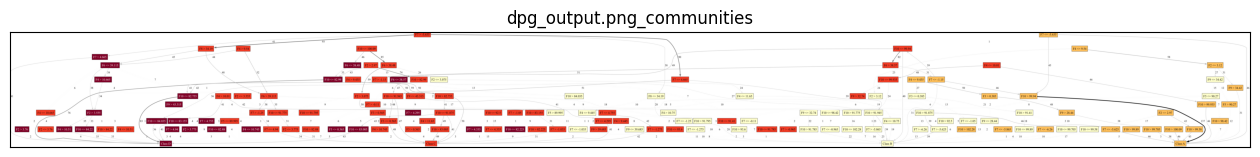

In [12]:
feature_names = X.columns.tolist()
class_names = np.unique(y).astype(str).tolist()

dpg = DecisionPredicateGraph(
    model=model,
    feature_names=feature_names,
    target_names=class_names
)
dot = dpg.fit(X.values)
dpg_model, nodes_list = dpg.to_networkx(dot)

# =============================================================================
# METRICS EXTRACTION
# =============================================================================
dpg_metrics = GraphMetrics.extract_graph_metrics(dpg_model, nodes_list,target_names=np.unique(y).astype(str).tolist())
df_nodes = NodeMetrics.extract_node_metrics(dpg_model, nodes_list)


df_edges = get_dpg_edge_metrics(dpg_model, nodes_list)

plot_dpg("dpg_output.png", dot, df_nodes, df_edges, dpg_metrics, save_dir="../datasets", communities=True, class_flag=False)


## Communities

In [13]:
import pandas as pd

rows = []
for group in dpg_metrics["Communities"]:
    class_name = [s for s in group if s.startswith("Class")][0]
    predicates = group - {class_name}
    for pred in predicates:
        rows.append({"Class": class_name, "Predicate": pred})

df = pd.DataFrame(rows)

# Group predicates by class
grouped_df = df.groupby("Class")["Predicate"].apply(lambda x: ", ".join(sorted(x))).reset_index()
grouped_df

,Class,Predicate
0,Class A,"F10 > 100.09, F10 > 102.28, F10 > 98.42, F10 > 99.58, F10 > 99.705, F10 > 99.89, F10 > 99.935, F10 > 99.94, F2 <= 2.97, F2 <= 3.12, F3 > 0.385, F4 <= 9.435, F4 <= 9.54, F5 > 90.27, F7 <= -1.15, F7 <= -5.625, F7 <= -5.635, F7 <= -5.865, F7 <= -6.26, F9..."
1,Class B,"F10 <= 102.28, F10 <= 98.42, F10 <= 99.58, F10 <= 99.705, F10 <= 99.89, F10 > 84.035, F10 > 91.41, F10 > 91.775, F10 > 91.785, F10 > 91.795, F10 > 91.875, F10 > 91.945, F10 > 92.5, F10 > 93.6, F2 <= 3.075, F2 > 3.12, F3 <= 0.385, F4 <= 10.75, F4 <= 11..."
2,Class C,"F10 <= 100.09, F10 <= 91.41, F10 <= 91.775, F10 <= 91.785, F10 <= 91.795, F10 <= 91.875, F10 <= 91.945, F10 <= 92.5, F10 <= 93.6, F10 <= 99.935, F10 <= 99.94, F10 > 82.225, F10 > 82.755, F10 > 82.88, F10 > 82.99, F10 > 83.005, F10 > 83.155, F10 > 84.2..."
3,Class D,"F10 <= 82.225, F10 <= 82.755, F10 <= 82.88, F10 <= 82.99, F10 <= 83.005, F10 <= 83.155, F10 <= 84.035, F10 <= 84.22, F2 > 3.555, F2 > 3.76, F2 > 3.775, F3 <= 0.365, F4 <= 10.745, F4 > 10.51, F4 > 10.665, F6 <= 38.48, F6 <= 38.57, F6 <= 39.115, F7 > 4...."


## Class Bounds

In [14]:
import pandas as pd

# Assuming dpg_metrics is already defined and contains "Class Bounds"
class_bounds = dpg_metrics.get("Class Bounds", {})

# Convert to DataFrame: one row per class with constraints joined
df_bounds = pd.DataFrame([
    {"Class": class_name, "Constraints": ", ".join(sorted(bounds))}
    for class_name, bounds in class_bounds.items()
])

# Optional: sort alphabetically by class name
df_bounds = df_bounds.sort_values("Class")
df_bounds

,Class,Constraints
1,Class A,"-5.635 < F7 <= 4.665, 0.385 < F3 <= 0.385, 2.97 < F2 <= 3.12, 28.44 < F9 <= 34.42, 38.57 < F6 <= 38.48, 82.755 < F10 <= 100.09, 9.435 < F4 <= 10.01, 90.27 < F5 <= 90.27, F8 > 34.19"
3,Class B,"-6.26 < F7 <= 4.755, 0.385 < F3 <= 0.385, 2.97 < F2 <= 3.555, 28.44 < F9 <= 39.685, 34.19 < F8 <= 34.19, 38.48 < F6 <= 39.115, 82.755 < F10 <= 102.28, 89.995 < F5 <= 90.27, 9.435 < F4 <= 11.65"
2,Class C,"-5.635 < F7 <= 4.94, 0.365 < F3 <= 0.565, 2.97 < F2 <= 3.775, 32.74 < F9 <= 43.315, 34.19 < F8 <= 34.19, 38.48 < F6 <= 39.115, 82.225 < F10 <= 100.09, 89.995 < F5 <= 90.27, 9.435 < F4 <= 11.65"
0,Class D,"-5.635 < F7 <= 4.665, 0.565 < F3 <= 0.365, 32.74 < F9 <= 43.315, 34.19 < F8 <= 34.19, 38.48 < F6 <= 39.115, 82.755 < F10 <= 100.09, 9.435 < F4 <= 10.745, F2 > 2.97"


## Predicates (nodes) explanation

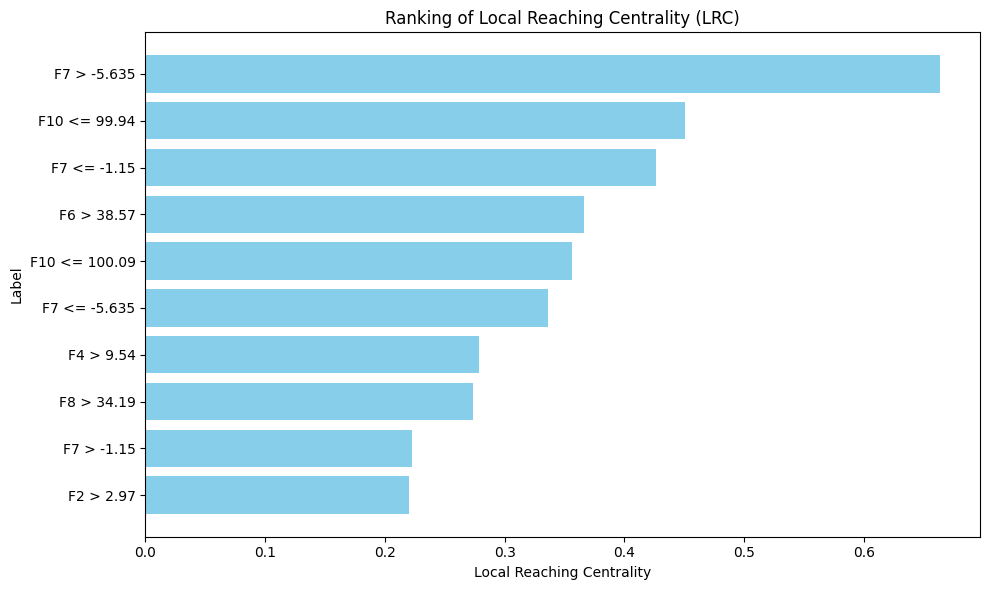

In [15]:
import matplotlib.pyplot as plt

# Sort by Local Reaching Centrality
df_sorted = df_nodes.sort_values("Local reaching centrality", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_sorted["Label"], df_sorted["Local reaching centrality"], color="skyblue")
plt.xlabel("Local Reaching Centrality")
plt.ylabel("Label")
plt.title("Ranking of Local Reaching Centrality (LRC)")
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()